The code in this repository is largely based on the work of Olga Ratushniak and Svitlana Myroshnychenko during their MSc thesis. For more information, please contact Beatriz Cabrero-Daniel.

Some imports:

In [2]:
import matplotlib.pyplot as plt
from matplotlib.ticker import StrMethodFormatter
import os
import pandas as pd
import zCurve as z
import numpy as np
from itertools import permutations

Please configure here how many bins should the Generic-CSP (G-CSP) have and what is the threshold for adding a bar in a CSP (barcode) to the G-CSP:

In [3]:
nbins = 20 # more bins = thinner bars
barthreshold = 2 # higher threshold = fewer bars
padding = 15

figsize = (7, 3) 

Reading some fake CSPs to illustrate the CSP (barcode) clustering mechanism. Feel free to play around with the signals.

In [4]:
listofcsps = []
namesoftraj = []

folder_path = "results/synthetic_turns_data"
files = [folder_path + "/" + f for f in os.listdir(folder_path) if os.path.isfile(os.path.join(folder_path, f))]
files.sort()
# files.reverse()

# ===============================
# DATA FILE PROCESSING
# ===============================
for file_path in files:
    if ".csv" not in file_path:
        continue
    
    # print(file_path)
    
    file_basename = os.path.splitext(os.path.basename(file_path))[0]
    data = pd.read_csv(file_path, sep=';')    
    data['timestamp'] = data['sampleTimeStamp.seconds'] * 1_000_000 + data['sampleTimeStamp.microseconds']
    
    accel_x = (data["accel_x"] + 10) * 100.0
    accel_y = (data["accel_y"] + 10) * 100.0
    
    # print(max(accel_x), max(accel_y))
    
    # ===============================
    # Plot 1: Vehicle Position Colored by Speed
    # ===============================    
    plt.figure()
    plt.scatter(data['x'], data['y'], c=data['speed'], cmap='viridis', s=20)
    plt.colorbar(label="Speed (m/s)")
    plt.scatter(data.iloc[-1]['x'], data.iloc[-1]['y'], s=100, color="black", edgecolors="white")
    plt.xlabel("Longitude (position x)")
    plt.ylabel("Latitude (position y)")
    plt.title(f"Vehicle trajectory: {file_basename}")
    plt.axis('equal')
    # plot1_filename = os.path.join(output_dir, f"{file_basename}_position.png")
    # plt.savefig(plot1_filename, bbox_inches="tight")
    # plt.show()
    plt.close()
    
    bits_per_dim = 8

    listofcsps +=  [[z.interlace(int(x), int(y), bits_per_dim=bits_per_dim) for x, y in zip(accel_x, accel_y)][padding+1:-padding]] #because padding (straight part of trajectory) is useless
    namesoftraj += [file_basename]

Configuration settings for the figures created below (you can ignore this):

In [5]:
cmap = plt.get_cmap('rainbow')
colors = [cmap(1/(len(listofcsps)-1)*i) for i in range(len(listofcsps))]
decforyaxis = StrMethodFormatter('{x:,.1f}')
allmortonindices = []
for csp in listofcsps:
    allmortonindices += csp
mortonindexmin = min(allmortonindices)
mortonindexmax = max(allmortonindices)
totalrange = mortonindexmax - mortonindexmin
margins = totalrange/50.0
numsignals = len(listofcsps)

Plotting the generated CSPs together:

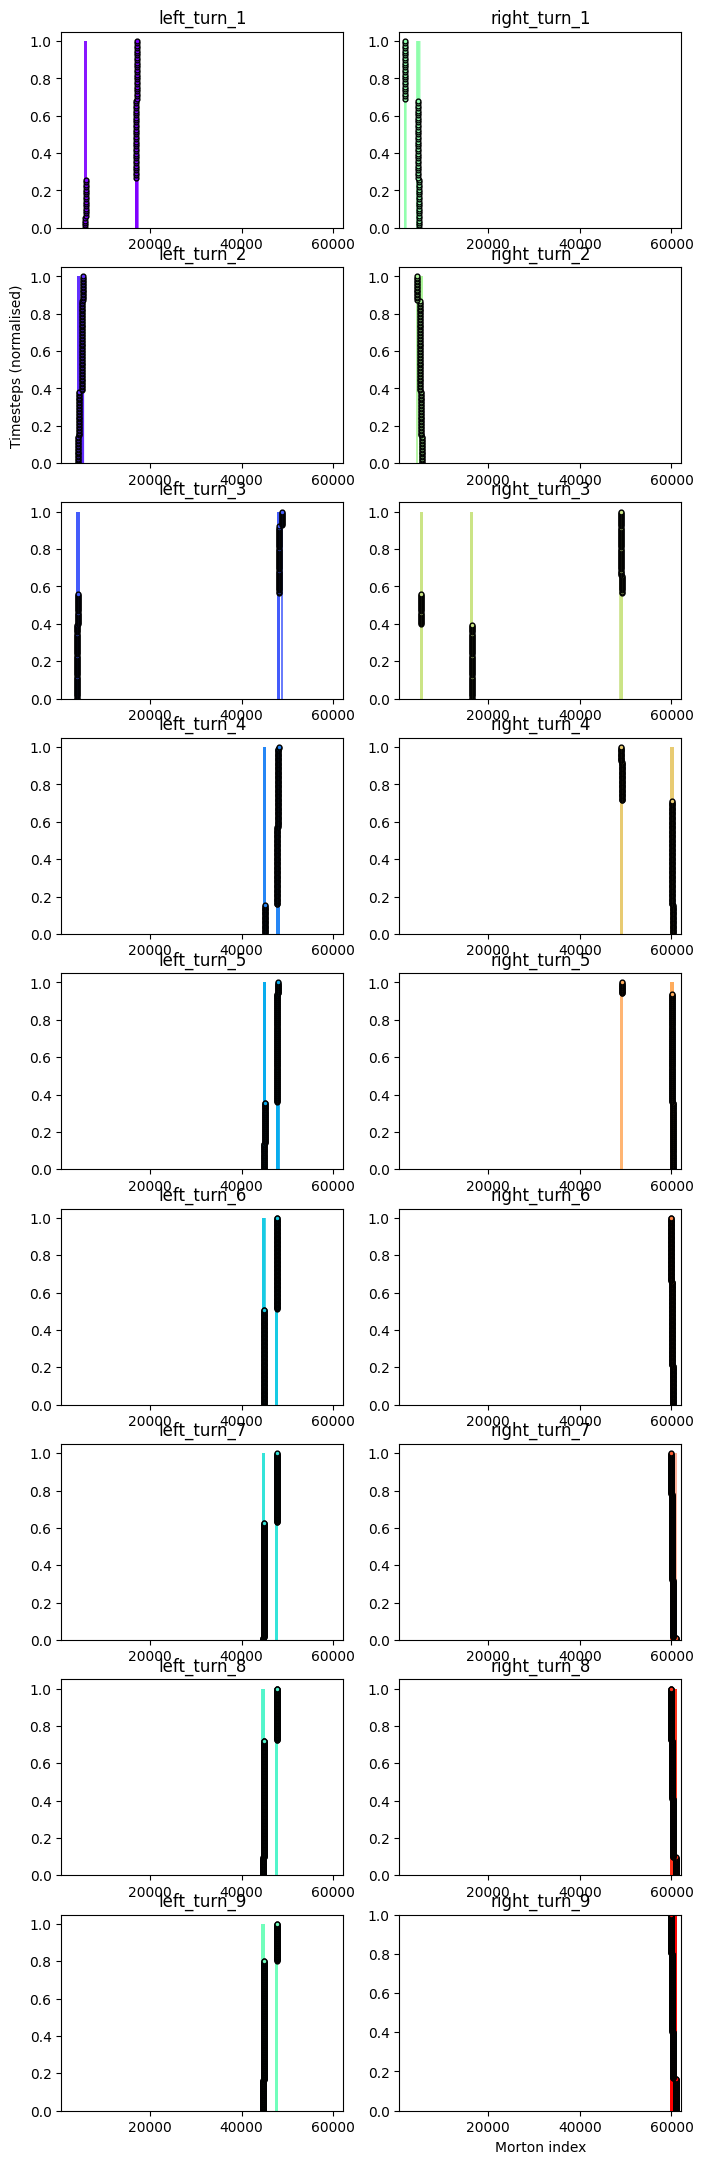

In [6]:
f, axes = plt.subplots(figsize=(8, 1.5*numsignals), nrows = (numsignals+1)//2, ncols= 2)
axes = np.atleast_2d(axes)

for i, csp in enumerate(listofcsps):    
    col = 0 if i < (numsignals + 1) // 2 else 1
    ax = axes[i if col == 0 else i - (numsignals + 1) // 2, col]    
    
    ax.bar(csp, [1 for _ in range(len(csp))], width=totalrange/100, color=colors[i], alpha=0.1)
    
for i, csp in enumerate(listofcsps):
    ranges = [x / (len(csp) - 1) for x in range(len(csp))]
    
    col = 0 if i < (numsignals + 1) // 2 else 1
    ax = axes[i if col == 0 else i - (numsignals + 1) // 2, col]
    
    ax.scatter(csp, ranges, color=colors[i], edgecolor="k", s=12)
    ax.set_title(namesoftraj[i])
    ax.set_xlim(mortonindexmin-margins, mortonindexmax+margins)
axes[1, 0].set_ylabel("Timesteps (normalised)")

plt.ylim(0, 1)
plt.gca().yaxis.set_major_formatter(decforyaxis)
plt.xlabel("Morton index")
plt.xlim(mortonindexmin-margins, mortonindexmax+margins)
# plt.tight_layout(rect=[0, 0, 1, 1.75])
plt.savefig("results/generic_csps/1csps.png")
plt.show()
plt.close()

Count bars in CSPs (barcodes) in each bin (same width):

In [7]:
bincounter = [0]*nbins
for m in allmortonindices:
    assigned = False
    for bin in range(nbins):
        binmin = mortonindexmin + totalrange/nbins*bin
        binmax = binmin + totalrange/nbins
        if binmin <= m < binmax:
            bincounter[bin] += 1
            assigned = True
    if not assigned:
        bincounter[-1] += 1

Draw the histogram for the bars in the CSPs (aggregated):

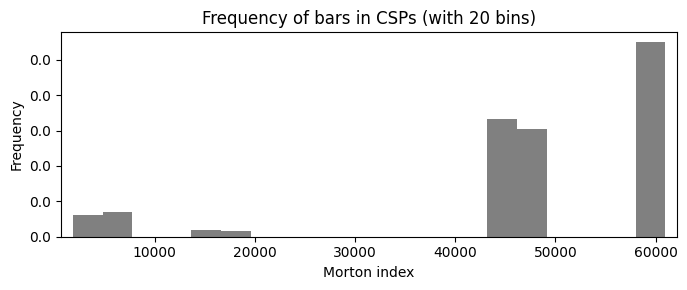

In [8]:
plt.figure(figsize=figsize)
plt.hist(allmortonindices, density=True, color="gray", bins=nbins)
plt.ylabel("Frequency")
plt.gca().yaxis.set_major_formatter(decforyaxis)
plt.xlabel("Morton index")
plt.xlim(mortonindexmin-margins, mortonindexmax+margins)
plt.title("Frequency of bars in CSPs (with "+str(nbins)+" bins)")
plt.tight_layout()
plt.savefig("results/generic_csps/2barfreq_nbins"+str(nbins)+".png")
plt.show()
plt.close()

Draw the generated G-CSP based on the frequency (the amount of bars in each of the bins):

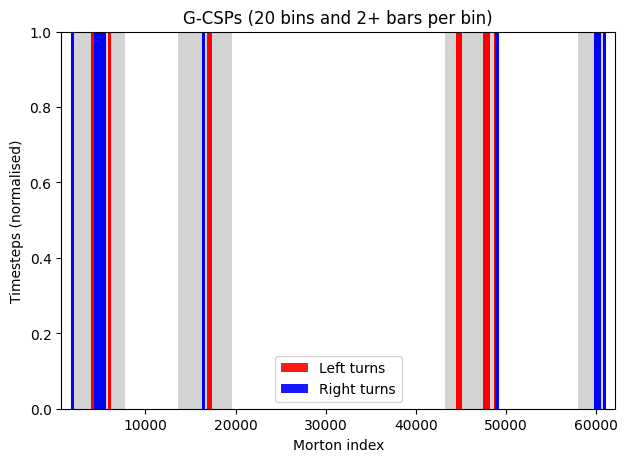

In [9]:
plt.figure()
plt.bar([totalrange/nbins/2+mortonindexmin+totalrange/(nbins)*x for x in range(nbins)], [1 if b > barthreshold else 0 for b in bincounter], width=totalrange/nbins, color="lightgray")

seenlabels = []

for i, csp in enumerate(listofcsps):    
    ranges = [x / (len(csp) - 1) for x in range(len(csp))]
    
    # speed = int(namesoftraj[i].split("_speed")[1][0])
    # radius = int(namesoftraj[i].split("_radius")[1][0])
   
    colour = "black"
    label = ""
    # if speed > 5 and radius > 3:
    #     colour = "red"
    #     label = "Big radius, high speed"
    # elif speed > 5 and radius <= 3:
    #     colour = "green"
    #     label = "Small radius, high speed"
    # elif speed <= 5 and radius > 3:
    #     colour = "blue"
    #     label = "Big radius, low speed"
    # elif speed <= 5 and radius <= 3:
    #     colour = "yellow"
    #     label = "Small radius, low speed"
    if i < (numsignals+1)//2:
        colour = "red"
        label = "Left turns"
    else:
        colour = "blue"
        label = "Right turns"
    
    
    if label in seenlabels:
        # plt.scatter(csp, ranges, color=colour, s=12)
        plt.bar(csp, [1 for _ in range(len(csp))], width=totalrange/200, color=colour, alpha=0.9)
    else:
        # plt.scatter(csp, ranges, color=colour, s=1, label=label)
        plt.bar(csp, [1 for _ in range(len(csp))], width=totalrange/200, color=colour, alpha=0.9, label=label)
        seenlabels.append(label)
        
plt.ylabel("Timesteps (normalised)")
plt.ylim(0, 1)
plt.gca().yaxis.set_major_formatter(decforyaxis)
plt.xlabel("Morton index")
plt.xlim(mortonindexmin-margins, mortonindexmax+margins)
plt.legend()
plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.title("Morton G-CSPs ("+str(nbins)+" bins and " + str(barthreshold)+"+ bars per bin)")
plt.title("G-CSPs ("+str(nbins)+" bins and " + str(barthreshold)+"+ bars per bin)")
plt.savefig("results/generic_csps/3gcsps_nbins"+str(nbins)+".png")
plt.show()


In [20]:
highlighted_bins = [i if b > barthreshold else 0 for i, b in enumerate(bincounter)]
highlighted_bins = [x for x in highlighted_bins if x > 0]



[1, 4, 5, 14, 15, 19]